# Lab 16 Assignment 3 - Group Assignment

When creating ML models, the concept of efficiency has three sides:
1. The time dedicated by the analyst to build the model
2. The computer time and resources needed by the final model
3. The accuracy of the final model

Efficiency is a combination of all

In this assignment, you are asked to be efficient. Spark is the best tool to build models over massive datasets

If you need to create Spark+Python Machine Learning models that "run fast" on the  cluster, you must avoid using Python code or working with RRD+python. Try to use  the already existing methods that do what you need (do not reinvent the wheel).

Therefore try to use the implemented object+methods inside the Spark SQL and ML modules. They are very fast, because it is compiled Java/Scala code. Try to use: DataFrames, Feature Transfomers, Estimators, Pipelines, GridSearch, CV, ...

For this assignment, you are asked to create a classification model that:
1. Uses the variables in the dataset (train.csv) to predict label "loan_status"
2. Write a python scripts that:
    - Reads the "train.csv" and "test.csv" files, transform and select variables as you wish.
    - Train/fit your model using the "train.csv".
    - Predict your model on the "test.csv" ( you should generate a file with your predictions).
    - I will use a different test dataset (with the true loan_status).

Your work will be evaluated under the following scoring schema
- (40%) ETL process
- (40%) Model train process
- (10%) Code Readability 
- (10%) AUC on the test set (at least 50%)

Enjoy it and best of luck!!


This Assignment is based on kaggle competition https://www.kaggle.com/c/loan-default-prediction from where a sub-dataset has been taken.

### File descriptions
**train.csv** - the training set (to use for building a model)

**test.csv** - the test set (to use for applying predictings)

**sample_submission.csv** - a template for the submission file

### Data Description (also contained in LendingClub_DataDescription.csv)
**ID**: A unique LC assigned ID for the loan listing.

**loan_amnt**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**loan_status**: Current status of the loan (**Target**: 1 = Charged Off, 0 = Fully Paid).

**term**: The number of payments on the loan. Values are in months and can be either 36 or 60.

**int_rate**: Interest Rate on the loan.

**installment**: The monthly payment owed by the borrower if the loan originates.

**emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

**home_ownership**: The home ownership status provided by the borrower during registration. Our values are: OTHER/NONE, MORTGAGE, OWN, RENT.

**annual_inc**: The self-reported annual income provided by the borrower during registration.

**purpose**: A category provided by the borrower for the loan request.

**title**: The loan title provided by the borrower.

**STATE**: The state provided by the borrower in the loan application.

**delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.

**revol_bal**: Total credit revolving balance.

**revol_util**: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

**total_pymnt**: Indicates total payment at the end of the loan.

In [2]:
import os
import sys

os.environ['SPARK_HOME'] = "/Users/ailleren/Documents/Spark/spark-2.3.2-bin-hadoop2.7"

# Create a variable for our root path
SPARK_HOME = os.environ['SPARK_HOME']

#Add the following paths to the system path. Please check your installation
#to make sure that these zip files actually exist. The names might change
#as versions change.
sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.7-src.zip"))

#Initialize SparkSession and SparkContext
from pyspark.sql import SparkSession

#Create a Spark Session
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("MiPrimer") \
    .config("spark.executor.memory", "6g") \
    .config("spark.cores.max","4") \
    .getOrCreate()


#Get the Spark Context from Spark Session    
sc = spark.sparkContext

ModuleNotFoundError: No module named 'pyspark'

### 1. Read the files into a Dataframes and show them

In [2]:
loanDF = spark.read.format('csv') \
                .option("inferSchema", "true") \
                .option("delimiter", ";") \
                .option('header','true') \
                .load('../data/train.csv')

testDF = spark.read.format('csv') \
                .option("inferSchema", "true") \
                .option("delimiter", ";") \
                .option('header','true') \
                .load('../data/test.csv')

In [3]:
loanDF.limit(10).toPandas()

,ID,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,title,STATE,delinq_2yrs,revol_bal,revol_util,total_pymnt,loan_status
0,2,2500,60 months,15.27%,59.83,< 1 year,RENT,30000.0,car,bike,GA,0,1687,0.094,1014.530000,1
1,4,10000,36 months,13.49%,339.31,10+ years,RENT,49200.0,other,personel,CA,0,5598,0.21,12231.890000,0
2,5,3000,60 months,12.69%,67.79,1 year,RENT,80000.0,other,Personal,OR,0,27783,0.539,4066.908161,0
3,6,5000,36 months,7.90%,156.46,3 years,RENT,36000.0,wedding,My wedding loan I promise to pay back,AZ,0,7963,0.283,5632.210000,0
4,7,7000,60 months,15.96%,170.08,8 years,RENT,47004.0,debt_consolidation,Loan,NC,0,17726,0.856,10137.840010,0
5,8,3000,36 months,18.64%,109.43,9 years,RENT,48000.0,car,Car Downpayment,CA,0,8221,0.875,3939.135294,0
6,10,5375,60 months,12.69%,121.45,< 1 year,RENT,15000.0,other,Building my credit history.,TX,0,9279,0.365,1484.590000,1
7,11,6500,60 months,14.65%,153.45,5 years,OWN,72000.0,debt_consolidation,High intrest Consolidation,AZ,0,4032,0.206,7678.017673,0
8,12,12000,36 months,12.69%,402.54,10+ years,OWN,75000.0,debt_consolidation,Consolidation,CA,0,23336,0.671,13947.989160,0
9,14,3000,36 months,9.91%,96.68,3 years,RENT,15000.0,credit_card,citicard fund,IL,0,7323,0.431,3480.269999,0


In [4]:
testDF.limit(10).toPandas()

,ID,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,title,STATE,delinq_2yrs,revol_bal,revol_util,total_pymnt,loan_status
0,1,5000,36 months,10.65%,162.87,10+ years,RENT,24000.0,credit_card,Computer,AZ,0,13648,0.84,5863.155187,1
1,3,2400,36 months,15.96%,84.33,10+ years,RENT,12252.0,small_business,real estate business,IL,0,2956,0.99,3005.666844,1
2,9,5600,60 months,21.28%,152.39,4 years,OWN,40000.0,small_business,Expand Business & Buy Debt Portfolio,CA,0,5210,0.33,647.500000,1
3,13,9000,36 months,13.49%,305.38,< 1 year,RENT,30000.0,debt_consolidation,freedom,VA,0,10452,0.92,2277.320000,1
4,15,10000,36 months,10.65%,325.74,3 years,RENT,100000.0,other,Other Loan,CA,0,11997,0.56,7471.990000,1
5,18,3600,36 months,6.03%,109.57,10+ years,MORTGAGE,110000.0,major_purchase,Holiday,CT,0,22836,0.16,3785.271965,1
6,26,15000,36 months,9.91%,483.38,2 years,MORTGAGE,92000.0,credit_card,No more credit card debt!,IL,0,13707,0.94,15823.999050,1
7,27,15000,36 months,14.27%,514.64,9 years,RENT,60000.0,debt_consolidation,consolidation,NY,0,5872,0.58,0.000000,1
8,29,4000,36 months,11.71%,132.31,10+ years,MORTGAGE,106000.0,debt_consolidation,Debt Consolidation,FL,1,6110,0.38,4486.293519,1
9,31,4375,36 months,7.51%,136.11,7 years,MORTGAGE,17108.0,debt_consolidation,Debt Consolidation,NY,0,11210,0.87,4899.960000,1


### 2. Analizing null values, cross tables distribution and covariances

#### ETL summary

You should explain how you are going to clean and prepare the data

In [ ]:
#Import libraries and functions required in the process
from pyspark.sql.functions import isnan
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt


In [76]:
loanDF.dtypes
#loanDF.describe().show()

[('ID', 'int'),
 ('loan_amnt', 'int'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'double'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('STATE', 'string'),
 ('delinq_2yrs', 'int'),
 ('revol_bal', 'int'),
 ('revol_util', 'string'),
 ('total_pymnt', 'double'),
 ('loan_status', 'int')]

In [30]:
#We notice Interest rate and Revolving utilization line were read as String. Hence, we create new columns as Float.
loanDF1 = loanDF.withColumn('int_rate_num', loanDF['int_rate'].substr(1, 4))
loanDF2 = loanDF1.withColumn("int_rate_num", loanDF1["int_rate_num"].cast(FloatType()))
loanDF3 = loanDF2.withColumn('revol_util_num', loanDF2['revol_util'].substr(1, 4))
loanDF4 = loanDF3.withColumn("revol_util_num", loanDF3["revol_util_num"].cast(FloatType()))

loanDF4.limit(10).toPandas()
loanDF4.dtypes

[('ID', 'int'),
 ('loan_amnt', 'int'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'double'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('STATE', 'string'),
 ('delinq_2yrs', 'int'),
 ('revol_bal', 'int'),
 ('revol_util', 'string'),
 ('total_pymnt', 'double'),
 ('loan_status', 'int'),
 ('int_rate_num', 'float'),
 ('revol_util_num', 'float')]

Exploring data: 'Five Number summary' and 'Missing or NA analysis'

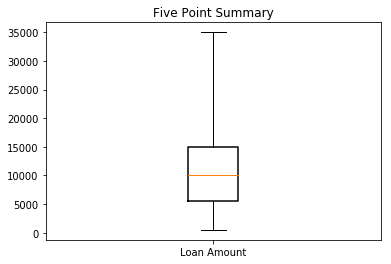

In [38]:
####Calculating Min, Q1, Median, Mean, Q3 and Max values for each numeric variable####

#Loan Amount
summary = loanDF4.describe("loan_amnt")
#summary.printSchema()
#summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['loan_amnt'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['loan_amnt'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['loan_amnt'].iloc[0]

medianAndQuantiles = loanDF4.stat.approxQuantile("loan_amnt",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

#Boxplot from precomputed values
item = {}

item["label"] = 'Loan Amount' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

In [59]:
#Show missing values (maybe keep)
loanDF.filter((loanDF["loan_amnt"] == "") | loanDF["loan_amnt"].isNull() | isnan(loanDF["loan_amnt"])).count()

0

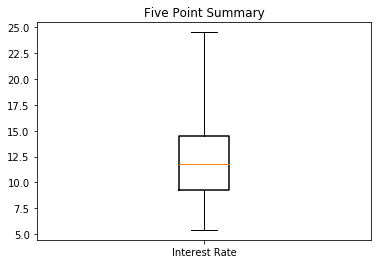

In [40]:
#Interest Rate
summary = loanDF4.describe("int_rate_num")
#summary.printSchema()
#summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['int_rate_num'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['int_rate_num'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['int_rate_num'].iloc[0]

medianAndQuantiles = loanDF4.stat.approxQuantile("int_rate_num",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

#Boxplot from precomputed values
item = {}

item["label"] = 'Interest Rate' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

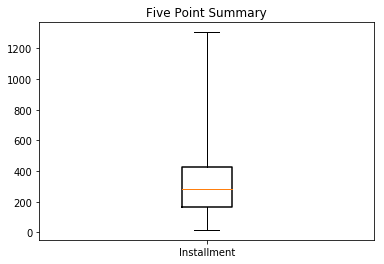

In [33]:
#Installment
summary = loanDF4.describe("installment")
#summary.printSchema()
#summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['installment'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['installment'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['installment'].iloc[0]

medianAndQuantiles = loanDF4.stat.approxQuantile("installment",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

#Boxplot from precomputed values
item = {}

item["label"] = 'Installment' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

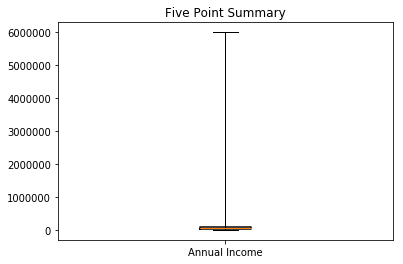

In [37]:
#Annual Income
summary = loanDF4.describe("annual_inc")
#summary.printSchema()
#summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['annual_inc'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['annual_inc'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['annual_inc'].iloc[0]

medianAndQuantiles = loanDF4.stat.approxQuantile("annual_inc",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

#Boxplot from precomputed values
item = {}

item["label"] = 'Annual Income' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

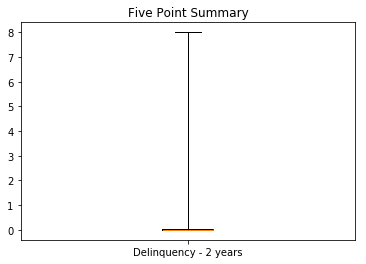

In [36]:
#Delinquency - 2 years
summary = loanDF4.describe("delinq_2yrs")
#summary.printSchema()
#summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['delinq_2yrs'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['delinq_2yrs'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['delinq_2yrs'].iloc[0]

medianAndQuantiles = loanDF4.stat.approxQuantile("delinq_2yrs",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

#Boxplot from precomputed values
item = {}

item["label"] = 'Delinquency - 2 years' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

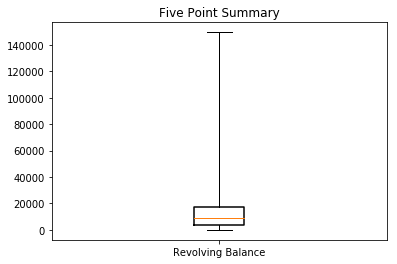

In [39]:
#Revolving balance
summary = loanDF4.describe("revol_bal")
#summary.printSchema()
#summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['revol_bal'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['revol_bal'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['revol_bal'].iloc[0]

medianAndQuantiles = loanDF4.stat.approxQuantile("revol_bal",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

#Boxplot from precomputed values
item = {}

item["label"] = 'Revolving Balance' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

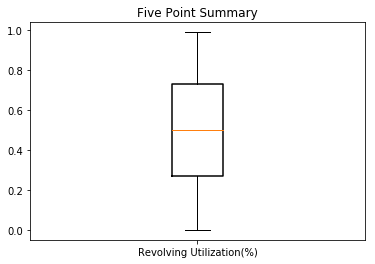

In [41]:
#Revolving utilization (%)
summary = loanDF4.describe("revol_util_num")
#summary.printSchema()
#summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['revol_util_num'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['revol_util_num'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['revol_util_num'].iloc[0]

medianAndQuantiles = loanDF4.stat.approxQuantile("revol_util_num",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

#Boxplot from precomputed values
item = {}

item["label"] = 'Revolving Utilization(%)' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

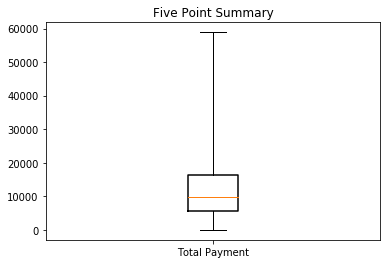

In [42]:
#Total Payment
summary = loanDF4.describe("total_pymnt")
#summary.printSchema()
#summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['total_pymnt'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['total_pymnt'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['total_pymnt'].iloc[0]

medianAndQuantiles = loanDF4.stat.approxQuantile("total_pymnt",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

#Boxplot from precomputed values
item = {}

item["label"] = 'Total Payment' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

In [ ]:
#Barchart showing distribution of Loan Status

TypeError: unsupported operand type(s) for +: 'int' and 'DataFrame'

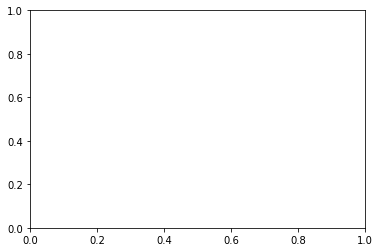

In [70]:
loan_status = loanDF4.select("loan_status")
plt.bar(2, loan_status, align='center', alpha=0.5)
#####NOT WORKING##### PENDING

In [ ]:
objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

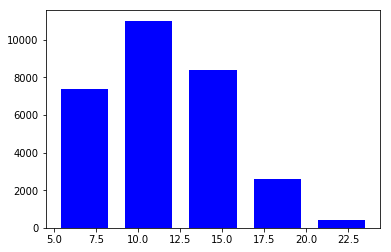

In [71]:
#Histogram
(startValues,counts) = loanDF4.select("int_rate_num").rdd.map(lambda value: value[0]).histogram(5)
#print(startValues)
#print(counts)

mid_point_bins = startValues[:-1]
widths = [abs(i - j+1) for i, j in zip(startValues[:-1], startValues[1:])]
bar = plt.bar(mid_point_bins, counts, width=widths, color='b', align='edge')
plt.show()

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
carrier_count = loanDF4.select("STATE")
#sns.set(style="darkgrid")
#sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
#plt.title('Frequency Distribution of Carriers')
#plt.ylabel('Number of Occurrences', fontsize=12)
#plt.xlabel('Carrier', fontsize=12)
#plt.show()

### Cross table distribution and Covariances

### 2.1 Spark code about the one explained in "ETL Summary"

### 2.2 Spark code about the transformations you apply to the variables

### 2.3 Code to assemble the variables to a numerical vector (VectorAssembler)

### 2.4 Create Pipeline for train and test data

### 3. Logistic Regresion Model

### 3.1 Write a function "metrics" which has a LogisticRegressionModel.summary as input attribute and produces an output of: 
1. Area under ROC
2. False Positive Rate By Label
3. True Positive Rate By Label
4. Precision By Label
5. Recall By Label
6. fMeasure By Label
7. Accuracy
8. False Positive Rate
9. True Positive Rate
10. fMeasure
11. Precision
12. Recall

In [ ]:
def metrics(trainingSummary):
    
    
    
    

### 3.2 Apply a Logistic Regresion Base Model and show the metrics by the function above

### 3.2 We are going to try to improve our model:
1. Using a `weight column` in our Logistic Regression Model (Take into account we are working with a unbalanced dataset)
2. Define a `ParamGridBuilder` with `regParam`, `elasticNetParam` and `maxIter` at least
3. Define an `BinaryClassificationEvaluator`
4. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:
1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which are the metrics of the best model (training) in the 5 k-fold runs? (Use the function above)
5. Which is the ROC-AUC on validation dataset?


### 4. Random Forest Model
1. Define a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

### 5. Gradient Boosting Model
1. Defining a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least (You can use the above one)
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

### 6. Apply your best model to send the predictions on test

In [155]:
sc.stop()